In [181]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data


class RBM(nn.Module):
    """Restricted Boltzmann Machine."""

    def __init__(self, n_vis, n_hid, k=1, *args, **kwargs):
        """Create a RBM."""
        super().__init__()
        self.a = nn.Parameter(torch.randn(1, n_vis))  # Bias for visible units
        self.b = nn.Parameter(torch.randn(1, n_hid))  # Bias for hidden units
        self.W = nn.Parameter(torch.randn(n_hid, n_vis))  # Weight parameter
        self.k = k  # The number of iteration in CD-k method

    def encode(self, v, binarize=False):
        """Conditional sampling a hidden variable given a visible variable.
        Args:
            v (Tensor): The visible variable.
            binarize (bool): Applying Bernoulli sampling. Default, False.
        Returns:
            Tensor: The hidden variable.
        """
        p = torch.sigmoid(F.linear(v, self.W, self.b))
        return p.bernoulli() if binarize else p

    def decode(self, h, binarize=False):
        r"""Conditional sampling a visible variable given a hidden variable.
        Args:
            h (Tendor): The hidden variable.
            binarize (bool): Applying Bernoulli sampling. Default, False.
        Returns:
            Tensor: The visible variable.
        """
        p = torch.sigmoid(F.linear(h, self.W.t(), self.a))
        return p.bernoulli() if binarize else p

    def free_energy(self, v):
        r"""Free energy function.
        .. math::
            \begin{align}
                F(x) &= -\log \sum_h \exp (-E(x, h)) \\
                &= -a^\top x - \sum_j \log (1 + \exp(W^{\top}_jx + b_j))\,.
            \end{align}
        Args:
            v (Tensor): The visible variable.
        Returns:
            FloatTensor: The free energy value.
        """
        v_term = torch.matmul(v, self.a.t())
        w_x_h = F.linear(v, self.W, self.b)
        h_term = torch.sum(F.softplus(w_x_h), dim=1)
        return torch.mean(-h_term - v_term)

    def gibbs_sampling(self, v, k):
        """
        Approximation of the Gibbs sampling of visible & hidden units
        using CD-k method.
        """
        for _ in range(k):
            h = self.encode(v, binarize=True)  # Binary
            v = self.decode(h, binarize=False)  # Real
        h = self.encode(v, binarize=False)  # Real
        return v, h

    def forward(self, v):
        v, h = self.gibbs_sampling(v, self.k)
        return v

    def visible_to_hidden(self, v):
        # Depreciated
        return self.encode(v, binarize=True)

    def hidden_to_visible(self, h):
        # Depreciated
        return self.decode(h, binarize=True)

    def train(self, tensor, lr):
        """
        Updating a internal parameters from input batch tensor
        Args:
            tensor (torch.Tensor): Input picture tensor. The shape must be [batch_size, [vectors]]
            lr (float): Learning rate
        """ 
        batch = tensor.size(0)
        v0 = tensor.view(batch, -1)
        h0 = self.encode(v0, binarize=False)
        vk, hk = self.gibbs_sampling(v0, self.k)

        eta = lr / batch
        # print((torch.mm(h0.t(), v0) - torch.mm(hk.t(), vk)).shape)
        self.W.data += eta * (torch.mm(h0.t(), v0) - torch.mm(hk.t(), vk))
        #self.b.data += eta * (torch.sum(v0 - vk), 0)
        self.a.data += eta * torch.sum(v0 - vk, 0)
        #self.a.data += eta * (torch.sum(h0 - hk), 0)
        self.b.data += eta * torch.sum(h0 - hk, 0)

        return F.mse_loss(v0, vk) / batch

    def recon_loss(self, tensor):
        batch = tensor.size(0)
        v0 = tensor.view(batch, -1)
        vk = self.forward(v0)
        return F.mse_loss(v0, vk) / batch
        



class Encoder(nn.Module):
    def __init__(self, n_vis, n_hid):
        super().__init__()
        self.fc1 = nn.Linear(n_vis, n_hid)

    def forward(self, v):
        v = torch.relu(self.fc1(v))
        return v


class Decoder(nn.Module):
    def __init__(self, n_vis, n_hid):
        super().__init__()
        self.fc1 = nn.Linear(n_hid, n_vis)

    def forward(self, h):
        h = torch.relu(self.fc1(h))
        return h


class AutoEncoder(nn.Module):
    def __init__(self, n_vis, n_hid):
        super().__init__()
        self.enc = Encoder(n_vis, n_hid)
        self.dec = Decoder(n_vis, n_hid)

    def forward(self, x):
        x = self.enc(x)
        x = self.dec(x)
        return x

    def visible_to_hidden(self, v):
        return self.enc(v)

    def hidden_to_visible(self, h):
        return self.dec(h)


In [182]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [183]:
from torchvision import datasets, transforms

batch_size = 128
n_vis = 784
n_hid = 784
k = 1
n_epochs = 30
lr = 0.01

train_datasets = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(0, 1)])
    )
train_loader = torch.utils.data.DataLoader(
    dataset=train_datasets,
    batch_size=batch_size,
    shuffle=True,
)
test_datasets = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_datasets,
    batch_size=batch_size,
    shuffle=True
)

In [184]:
from tqdm import tqdm
import numpy as np

model = RBM(n_hid=n_hid, n_vis=n_vis, k=k)

nfs = []

for epoch in tqdm(range(n_epochs)):
    vv = np.zeros((len(train_datasets), n_hid))

    for idx, (data, target) in enumerate(train_loader):
        n_iter = len(train_loader) * epoch + idx
        recon_loss = model.train(data, lr=lr)
        test_data = next(iter(test_loader))[0]
        test_recon_loss = model.recon_loss(test_data)
        writer.add_scalars(f"RBM/hid_{n_hid}./recon_loss/",{"train": recon_loss, "test": test_recon_loss} ,n_iter)
        vv[idx*batch_size:(idx+1)*batch_size, :] = model.encode(data.view(-1, n_vis)).detach().cpu().numpy()
    nfs.append(vv)

100%|██████████| 30/30 [07:48<00:00, 15.62s/it]


In [186]:
writer.add_embedding(nfs[-1])

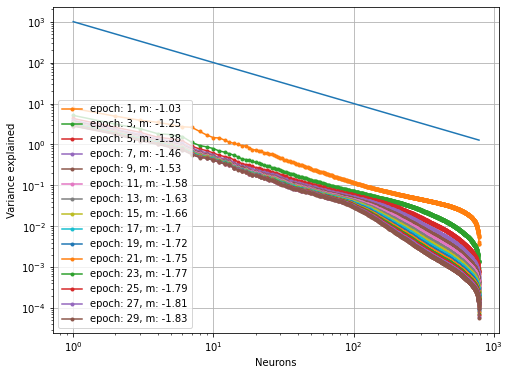

In [178]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

fig, ax = plt.subplots(figsize=(8, 6))
xx = np.arange(n_hid) + 1
log_xx = np.log(xx)
ax.plot(xx, 1000 * xx ** (-1.0))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Neurons')
ax.set_ylabel('Variance explained')

for i, vv in enumerate(nfs):
    if i % 2 == 1:
        continue
    pca = PCA()
    pca.fit(vv)
    yy = pca.explained_variance_
    log_yy = np.log(yy)
    m, c = np.linalg.lstsq(np.vstack([log_xx, np.ones(len(log_xx))]).T, log_yy, rcond=None)[0]
    ax.plot(xx, yy, '.-', label=f"epoch: {i+1}, m: {m:.3}")
plt.legend()
ax.grid()




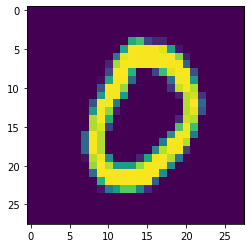

In [162]:
images = next(iter(test_loader))[0]
plt.imshow(images[0].numpy().reshape(28,28))

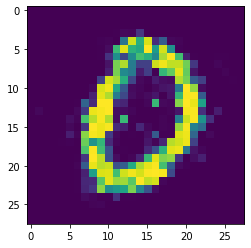

In [177]:
memorize_images = model.gibbs_sampling(images.view(batch_size, -1), k=1)[0]
plt.imshow(memorize_images[0].detach().numpy().reshape(28,28))

In [62]:
data, target = next(iter(test_loader))
print("data", data.shape)
print("label", target.shape)
v = data.view(-1, 784)
print("v", v.shape)

v = data.view(128, -1)
print("v", v.shape)
b = nn.Parameter(torch.randn(1, n_hid)) 
print("b", b.shape)
W = nn.Parameter(torch.randn(n_hid, n_vis))
print("W", W.shape)
h = torch.sigmoid(F.linear(v, W, b))
print("h", h.shape)

a = nn.Parameter(torch.randn(1, n_vis)) 
print("a", a.shape)

vk = torch.sigmoid(F.linear(h, W.t(), a))
print("vk", vk.shape)

torch.sum(v - vk, 0).view(-1, n_vis).shape

data torch.Size([128, 1, 28, 28])
label torch.Size([128])
v torch.Size([128, 784])
v torch.Size([128, 784])
b torch.Size([1, 100])
W torch.Size([100, 784])
h torch.Size([128, 100])
a torch.Size([1, 784])
vk torch.Size([128, 784])


torch.Size([1, 784])